# Python Functional Tensor-Train Chebyshev (FTTC) Dynamics for Simulation of Hydrogen Bonding in a Highly-Multidimensional DNA Chain

The following code enables simulation of Chebyshev dynamics in up to 47 dimensions through the use of function trains, a continuous analogue of tensor trains. Results are demonstrated for a model of hydrogen bonding in DNA.

In particular, FTTC expands the initial state as a functional tensor train of the form
$$
	f(x_1,x_2,\ldots,x_d)=\sum_{i_0=1}^{r_0}\sum_{i_1=1}^{r_1}\cdots\sum_{i_d=1}^{r_d} f_1^{i_0 i_1}(x_1)f_2^{i_1 i_2}(x_2)\ldots f_d^{i_{d-1} i_d}(x_d)
$$
where $f_k^{ij}:\mathcal{x}_k\to\mathbb{R}$, $\mathcal{x}_k$ denotes the domain of the $k$th physical dimension, with $r_{0}=r_{d}=1$ for single-output functions such as polynomials or linear elements.

FTTC evolves the wavepacket by applying the Chebyshev expansion of the time-evolution operator,
$$
	e^{-it\hat H}
	\approx\sum_{k=0}^{N-1} \left(2-\delta_{k,0}\right)(-i)^kJ_k(t)T_k(\bf{\mathcal{\hat H}})
$$
where $T_k(\bf{\mathcal{\hat H}})$ are Chebyshev polynomials of the Hamiltonian $\hat H$ in functional tensor-train format, $J_k(t)$ are the Bessel functions of the first kind, and $t$ is the final propagation time.

# Compressed Continuous Computation Python (c3py) Library.

Import the c3py library from Github.

In [4]:
!pip install mkl-devel
!git clone https://github.com/goroda/Compressed-Continuous-Computation.git c3
%cd c3
!mkdir build
%cd build
!cmake -DBUILD_TESTS=ON -DBUILD_EXAMPLES=ON -DBUILD_PROFILING=ON -DBUILD_BENCHMARKS=ON -DBUILD_UTILITIES=ON ..
!make install
!apt-get install swig
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'c3' already exists and is not an empty directory.
/content/c3/c3
/content/c3/c3/build
CMake Warning (dev) in CMakeLists.txt:
  No project() command is present.  The top-level CMakeLists.txt file must
  contain a literal, direct call to the project() command.  Add a line of
  code such as

    project(ProjectName)

  near the top of the file, but after cmake_minimum_required().

  CMake is pretending there is a "project(Project)" command on the first
  line.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The C compiler identification is GNU 9.4.0
-- The CXX compiler identification is GNU 9.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CX

Set up the c3py library.

In [5]:
!python setup.py build
!python setup.py install

python3: can't open file '/content/c3/c3/setup.py': [Errno 2] No such file or directory
python3: can't open file '/content/c3/c3/setup.py': [Errno 2] No such file or directory


**IMPORTANT:** Reset the runtime by clicking on "Runtime" above, then select "Restart Runtime" and continue. (Otherwise, the following outputs the error "ModuleNotFoundError: No module named 'c3py'".

In [1]:
import c3py

# FTTC Propagation

Import numpy for arrays, scipy for Bessel functions (jv), and matplotlib for plotting.

In [2]:
import numpy as np
from scipy.special import jv
import matplotlib.pyplot as plt

Define Chebyshev propagation parameters.

In [5]:
global round_eps,rmax
global dis

ncheb=50 # order of Chebyshev expansion (how many Chebyshev polynomials added up)
ne=32 # number of grid points per dimension
nx=ne**2 # total number of grid points
dim=2 # number of dimensions
nsteps=600 # number of propagation steps
ndump=100 # how often to report output
dis=1 # initial displacement
dt=0.01 # time increment
m=1 # mass
xmin=-5 # lower bound
xmax=5 # upper bound
dx=(xmax-xmin)/ne # position grid division
dp=2*np.pi/(xmax-xmin) # momentum grid division

#for rescaling
#vmin=-1*dim # minimum of potential
vmin=0 # Harmonic oscillator potential (min value of potential)
#vmax=34.9455*dim#33.9455*dim # maximum of potential # double well potential
vmax=0.5*(xmax**2)*dim # Harmonic oscillator potential (max value of potential)

Calculate the energy and time variables for Chebyshev propagation. This includes the bounds for the eigenvalues $E_\text{min}$ and $E_\text{max}$, which correspond to the smallest and largest possible energies, respectively, as well as the rescaled variables
$$
	t^\pm
	=\frac{t}{2}(b\pm a)
$$
corresponding to the matrix $H_0\in\mathbb{C}^{D\times D}$ with eigenvalues in $[-1,1]$
$$
	H_0
	=\frac{2}{b-a}\left(H-\frac{b+a}{2}\operatorname{I}_D\right)
$$
used in the Chebyshev expansion written in terms of a linear transformation of the argument $y$, we can restate Eq.~\eqref{eq:Cheby1} for an arbitrary Hermitian matrix $H\in\mathbb{C}^{D\times D}$ (where $D>1$ is a positive integer) with eigenvalues contained in a finite interval $[a,b]$ as follows
$$
	e^{-itH}
	\approx e^{-it^+}\sum_{k=0}^{N-1} \left(2-\delta_{k,0}\right)(-i)^kJ_k(t^-)T_k(H_0)
$$
where $\operatorname{I}_D$ is the $D\times D$ identity matrix.


In [6]:
emin=vmin # minimum energy (corresponds to zero momentum)
emax=np.pi**2/(2*dx**2)*dim+vmax # maximum energy,  first term (KE) : p_max^2 / 2 = (pi/dx)^2 / 2 (assume mass = 1)
dep=emax+emin #(b + a)
dem=emax-emin #(b - a)
dtm=dem*dt/2 #scaled time (t^-)
dtp=dep*dt/2 #scaled time (t^+)

Define time grid for printing.

In [7]:
tlist=np.arange(0,dt*(nsteps+1),dt)

Define position and momentum grids for printing.

In [8]:
xc=np.zeros(ne)
pc=np.zeros(ne)
for jy in range(ne):
  xc[jy]=xmin+dx*jy
  pc[jy]=dp*jy-dp*ne/2

In [9]:
basis="linelm" # function train basis (linear elements)
nparam=ne # number of linear elements in function train
# support of univariate functions in function trains
lb=[xc[0]]*dim #[xmin]*dim
ub=[xc[-1]]*dim #[xmax]*dim
round_eps=1e-8 # Rounding tolerance
rmax=5 # Maximum rank

The following function creates a functional tensor train.

In [10]:
def build_ft(func,args,dim,lb,ub,nparam,basis):

    ft = c3py.FunctionTrain(dim)
    for ii in range(dim):
        if basis == "piecewise":
            ft.set_dim_opts(ii,"piecewise",lb[ii],ub[ii],nparam=nparam,coeff_check=1,tol=1e-1,nregions=2)
        elif basis == "polynomial":
            ft.set_dim_opts(ii,"legendre",lb[ii],ub[ii],nparam=nparam,maxnum=40,coeff_check=1,tol=1e-3)
        elif basis == "linelm":
            ft.set_dim_opts(ii,"linelm",lb[ii],ub[ii],nparam=nparam,)

    verbose=0
    init_rank=3 # Initial rank
    adapt=0

    maxrank=10 # Maximum rank
    kickrank=1 # Kick rank
    crosstol=1e-15 # Cross tolerance
    roundtol=1e-15 # Rounding tolerance
    maxiter=5 # Maximum number of iterations

    ft.build_approximation(func,args,init_rank,verbose,
                           adapt,maxrank=maxrank,
                           round_tol=roundtol,
                           cross_tol=crosstol,
                           kickrank=kickrank,
                           maxiter=maxiter)
    return ft

We consider the initial state as a Gaussian of the form
$$
	\Psi_{0}\left(x\right)
	=\prod_{i=1}^D\sqrt[4]{\frac{\alpha}{\pi}}\exp\left(-\frac{\alpha}{2}\left(x_i-x_{0,i}\right)^{2}+\text{i}p_{0,i}\left(x_i-x_{0,i}\right)\right),
$$
with $x_{0,i}$ and $p_{0,i}$ the initial central position and momentum of the Gaussian, respectively.

For low-dimensional systems, uncomment the "psio" block and use the following code to generate an initial state as a Gaussian wavepacket.

In [12]:
def psio(r,param=None):
    global dis
    nevals,dim=r.shape
    out=np.zeros((nevals,))
    for ii in range(dim):
      if ii==0:
        out=np.exp(-0.5*(r[:,ii]-dis)**2)/np.pi**0.25
      else:
        #out=out*np.exp(-0.5*(r[:,ii])**2)/np.pi**0.25 # not displaced
        out=out*np.exp(-0.5*(r[:,ii]-dis)**2)/np.pi**0.25 # displaced
    return out

For high-dimensional systems, the difference of GS and GSfix gives the desired initial state as a Gaussian wavepacket. This method is used in high-dimensional systems to avoid undersampling in the cross approximation due to a large number of zero values.

In [13]:
def GS(r,param=None):
    global dis
    nevals,dim=r.shape
    out=np.zeros((nevals,))
    for ii in range(dim):
      if ii==0:
        out=np.exp(-0.5*(r[:,ii]-dis)**2)/np.pi**0.25
      else:
        #out=out*np.exp(-0.5*(r[:,ii])**2)/np.pi**0.25 # not displaced
        out=out*np.exp(-0.5*(r[:,ii]-dis)**2)/np.pi**0.25 # displaced
    out1=np.zeros((nevals,))
    for ii in range(dim):
      if ii==0:
        out1=np.exp(-0.5*(r[:,ii])**2/9.)/np.pi**0.25
      else:
        out1=out1*np.exp(-0.5*(r[:,ii])**2/9.)/np.pi**0.25
    out=1e7*(out+1e-5*out1)
    return out

def GSfix(r,param=None):
    nevals,dim=r.shape
    out1=np.zeros((nevals,))
    for ii in range(dim):
      if ii==0:
        out1=np.exp(-0.5*(r[:,ii])**2/9.)/np.pi**0.25
      else:
        out1=out1*np.exp(-0.5*(r[:,ii])**2/9.)/np.pi**0.25
    out1=1e7*(1e-5*out1)
    return out1

Define the potential energy surface.  Here options are given for a double well potential that corresponds to a scaled model of hydrogen bonding in a DNA chain
$$
	V\left(x_{1},x_{2},\ldots,x_{d}\right)
	=\sum_{i=1}^{D}\alpha\left(0.429~x_{i}-1.126~x_{i}^{2}-0.143~x_{i}^{3}+0.563~x_{i}^{4}\right)+\sum_{i>1}^{D}\alpha\beta\left(x_{i}x_{i-1}\right)
$$
where $\alpha=0.1\text{ au}$ determines the energy scaling of the model potential and $\beta$ is the hydrogen-bond coupling parameter and the harmonic oscillator potential.

In [14]:
def V(r,param=None):
    gamma=0.
    verticalscale=0.1
    nevals,dim=r.shape
    out=np.zeros((nevals,))
    for ii in range(dim):
        #if ii == 0: # Double well potential
        #  out=out+verticalscale*(0.429*r[:,ii]-1.126*r[:,ii]**2-0.143*r[:,ii]**3+0.563*r[:,ii]**4)
        #else:
        #  out=out+verticalscale*(0.429*r[:,ii]-1.126*r[:,ii]**2-0.143*r[:,ii]**3+0.563*r[:,ii]**4)
        #  out=out+verticalscale*gamma*r[:,ii]*r[:,ii-1]
      out=out+0.5*(r[:,ii])**2 # Harmonic oscillator potential
    return out

The following function produces a function train of zeros.

In [15]:
def zeros(r,param=None):
    nevals,dim=r.shape
    out=np.zeros((nevals,))
    return out

Build a functional tensor train of the potential energy.

In [16]:
ft_V=build_ft(V,None,dim,lb,ub,nparam,basis=basis)
ft_V.round(eps=round_eps,maxrank_all=rmax)

Plot a 2D slice of the potential energy functional tensor train.

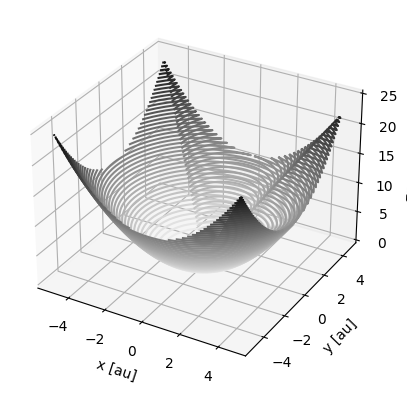

In [22]:
xcur=np.zeros(dim)
xmesh=np.zeros((nx,nx))
ymesh=np.zeros((nx,nx))
potentialvalue=np.zeros((nx,nx))
for jj in range(nx):
  jy=int(jj/ne)
  jx=int(jj-jy*ne)
  for ll in range(dim):
    xcur[ll]=0
  xcur[0]=xc[jx]
  xcur[1]=xc[jy]
  xmesh[jx][jy]=xcur[0]
  ymesh[jx][jy]=xcur[1]
  potentialvalue[jx][jy]=ft_V.eval(xcur)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(xmesh, ymesh, potentialvalue, 50, cmap='binary')
ax.set_xlabel('x [au]')
ax.set_ylabel('y [au]')
ax.set_zlabel('Energy [au]');

Build a functional tensor train of the initial state.

In [23]:
#if dim < 34:
#  ft_psir=build_ft(psio,None,dim,lb,ub,nparam,basis=basis)
#  ft_psir.round(eps=round_eps,maxrank_all=rmax)
#else:
ft_psir=build_ft(GS,None,dim,lb,ub,nparam,basis=basis) #bump gaussian
ft_psir.round(eps=round_eps,maxrank_all=rmax)
ft_psirfix=build_ft(GSfix,None,dim,lb,ub,nparam,basis=basis) #broad gaussian
ft_psirfix.round(eps=round_eps,maxrank_all=rmax)
ft_psir=ft_psir-ft_psirfix #subtract broad from bump
normcur=ft_psir.inner(ft_psir) #calculate norm
ft_psir.round(eps=round_eps,maxrank_all=rmax)
ft_psir.scale(1/np.sqrt(normcur)) #normalize
ft_psir.round(eps=round_eps,maxrank_all=rmax)
ft_psic=build_ft(zeros,None,dim,lb,ub,nparam,basis=basis) # set imag part to zero FT
ft_psic.round(eps=round_eps,maxrank_all=rmax)
ft_psion=ft_psir.copy() # initial state
ft_psion.round(eps=round_eps,maxrank_all=rmax)

Plot a 2D slice of the probability density corresponding to the initial state functional tensor train.

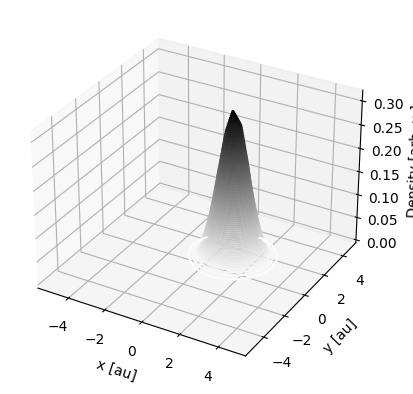

In [24]:
v_ft_psim=np.zeros((nx,nx))
for jj in range(nx):
  jy=int(jj/ne)
  jx=int(jj-jy*ne)
  for ll in range(dim):
    xcur[ll]=0
  xcur[0]=xc[jx]
  xcur[1]=xc[jy]
  v_ft_psir=ft_psir.eval(xcur)
  v_ft_psic=ft_psic.eval(xcur)
  v_ft_psim[jx][jy]=v_ft_psir**2+v_ft_psic**2

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(xmesh, ymesh, v_ft_psim, 100, cmap='binary')
ax.set_xlabel('x [au]')
ax.set_ylabel('y [au]')
ax.set_zlabel('Density [arb. u.]');

## Laplace
Build the analytic Laplace operator.

In [25]:
op = c3py.c3.build_lp_operator(dim,xc)

The following function computes the Hamiltonian as applied to the wavefunction with a scaling factor suitable for the Chebyshev expansion of the propagator as applied to the wavefunction:
$$
	\hat{H}
	=\frac{\hat{p}\cdot\hat{p}}{2m}+\hat V
	=-\frac{1}{2m}\Delta_x+\hat V
$$
where $m>0$ is the mass of the system, $\Delta_x$ is the Laplacian, and $V\colon\mathbb{R}^d\to\mathbb{R}$ is a given potential energy surface (PES) describing interactions that rule the underlying dynamics of the system. The Laplacian is calculated analytically from the function train.

In [26]:
def lap_prod_add(ft,coeff,dem,dep,m,ft_V,dim,lb,ub,nparam,basis,op):
    global round_eps,rmax
    temp=ft.laplace_op(op) #\Delta_x \Psi
    temp.scale(-coeff/(dem*m)) #Chebyshev scaling
    temp.round(eps=round_eps,maxrank_all=rmax)
    temp2=ft*ft_V # V \Psi
    temp2.scale(coeff*2/dem) #Chebyshev scaling
    temp2.round(eps=round_eps,maxrank_all=rmax)
    out = ft.copy() #\Psi copy
    out=out.scale(-coeff*dep/dem) #Chebyshev scaling
    out=temp+out
    out.round(eps=round_eps,maxrank_all=rmax)
    out=temp2+out
    out.round(eps=round_eps,maxrank_all=rmax)
    return out

## Clencheb

The following function computes the Chebyshev expansion of the propagator as applied to the wavefunction according to the Clenshaw approach.

For context, for all integers $k\ge 0$ and all $x\in [-1,1]$, the $k$th Chebyshev polynomial is defined as follows
$$
	T_k(x)
	=\cos\big(k\arccos(x)\big)
$$
where $\arccos$ is the inverse of the cosine (\emph{i.e.,} $\cos(\arccos(x))=\arccos(\cos(x))=x$), defined for input values $x\in[-1,1]$. The Chebyshev polynomials follow the recurrence relation
$$
	T_{k+1}(x)
	=2xT_k(x)-T_{k-1}(x)
$$
with $T_0(x)=1$ and $T_1(x)=x$ defining the subsequent Chebyshev polynomials, such that the first four polynomials are
$$
	T_0(x)
	=1,\quad
	T_1(x)
	=x,\quad
	T_2(x)
	=2x^2-1,\quad
	T_3(x)
	=4x^3-3x
$$


In the standard Chebyshev method, these polynomials are used to approximate a given complex-valued function $f$ via its Fourier series representation
$$
	f(y)
	=\sum_{k=0}^\infty \left(2-\delta_{k,0}\right)c_kT_k(y),
	\quad
	c_k
	=\frac{1}{\pi}\int_{-1}^1\frac{\mathrm{d}y}{\sqrt{1-y^2}}\,f(y)T_k(y),
$$
for $y\in [-1,1]$. This expansion of $f$ can be used to approximate $f$ as the linear combination of the first $N$ Chebyshev polynomials as follows
$$
	f(y)
	\approx S_Nf(y)
	=\sum_{k=0}^{N-1}\left(2-\delta_{k,0}\right)c_kT_k(y)
$$

The Clenshaw approach provides a more efficient approach to the Chebyshev expansion, as it replaces the summation of the traditional approach by the evaluation of the following backward recurrence system
$$
	\begin{cases}
		B_r(y)=2yB_{r+1}(y)-B_{r+2}(y)+c_r,\quad r=N-1,\dots,0;\\
		B_N(y)=0,\quad B_{N+1}(y)=0;
	\end{cases}
$$
The partial Chebyshev sum is then
$$
	\sum_{k=0}^{N-1}(2-\delta_{k,0})c_kT_k(y)
	=B_0(y)-B_2(y)
$$
This numerically stable procedure, memory-efficient procedure is implemented below.


In [27]:
def clencheb(ft_psir,ft_psic,ncheb,dep,dem,dtp,dtm,ft_V,m,dim,lb,ub,nparam,basis,op): # Clenshaw Chebyshev propagation

    global round_eps,rmax

    ft_cpolr=[None]*3
    ft_cpoli=[None]*3

    for ii in range(3):
        # builds 3 placeholder polynomials, sets to zero to start
        #real
      ft_cpolr[ii]=build_ft(zeros,None,dim,lb,ub,nparam,basis=basis)
      ft_cpolr[ii].round(eps=round_eps,maxrank_all=rmax)
      #imag
      ft_cpoli[ii]=build_ft(zeros,None,dim,lb,ub,nparam,basis=basis)
      ft_cpoli[ii].round(eps=round_eps,maxrank_all=rmax)

    for l in range(ncheb):

      ft_cpolr[2]=ft_cpolr[1].copy()
      ft_cpoli[2]=ft_cpoli[1].copy()
      ft_cpolr[1]=ft_cpolr[0].copy()
      ft_cpoli[1]=ft_cpoli[0].copy()

      kk=ncheb-1-l # new index, count backward
      mik=(-complex(0,1))**kk #phase factor, (-i)^kk

      #look at clenshaw for terms
      ft_temp1=ft_psir.copy() # copy real
      ft_temp1.scale(np.real(mik)) # multiply by 1,0,-1
      ft_temp2=ft_psic.copy() # copy imag
      ft_temp2.scale(-np.imag(mik)) #multiply by 1,0,-1
      ft_temp2=ft_temp1+ft_temp2
      ft_temp2.round(eps=round_eps,maxrank_all=rmax)
      ft_temp2.scale(jv(kk,dtm)) #multiplying by bessel function
      ft_temp2.round(eps=round_eps,maxrank_all=rmax)
      ft_cpolr[0]=ft_temp2.copy() # copy into real c_0
      ft_cpolr[0]=ft_cpolr[0]-ft_cpolr[2] #recursion
      ft_cpolr[0].round(eps=round_eps,maxrank_all=rmax)

        #same as above block, but for imag
      ft_temp3=ft_psir.copy()
      ft_temp3.scale(np.imag(mik))
      ft_temp4=ft_psic.copy()
      ft_temp4.scale(np.real(mik))
      ft_temp4=ft_temp3+ft_temp4
      ft_temp4.round(eps=round_eps,maxrank_all=rmax)
      ft_temp4.scale(jv(kk,dtm))
      ft_temp4.round(eps=round_eps,maxrank_all=rmax)
      ft_cpoli[0]=ft_temp4.copy()
      ft_cpoli[0]=ft_cpoli[0]-ft_cpoli[2]
      ft_cpoli[0].round(eps=round_eps,maxrank_all=rmax)

      # laplace + potential function, look at clenshaw
      ft_temp5=lap_prod_add(ft_cpolr[1],2.0,dem,dep,m,ft_V,dim,lb,ub,nparam,basis,op)
      ft_temp6=lap_prod_add(ft_cpoli[1],2.0,dem,dep,m,ft_V,dim,lb,ub,nparam,basis,op)

      # adds outcome of L + P to c_0 and saves as c_0
      ft_cpolr[0]=ft_temp5+ft_cpolr[0]
      ft_cpolr[0].round(eps=round_eps,maxrank_all=rmax)
      ft_cpoli[0]=ft_temp6+ft_cpoli[0]
      ft_cpoli[0].round(eps=round_eps,maxrank_all=rmax)

    # c_0 = c_0 - c_2, real
    ft_cpolr[0]=ft_cpolr[0]-ft_cpolr[2]
    ft_cpolr[0].round(eps=round_eps,maxrank_all=rmax)
    ft_psir=ft_cpolr[0].copy()

    # c_0 = c_0 - c_2, imag
    ft_cpoli[0]=ft_cpoli[0]-ft_cpoli[2]
    ft_cpoli[0].round(eps=round_eps,maxrank_all=rmax)
    ft_psic=ft_cpoli[0].copy()

    # scaling from phase, real
    ft_temp1=ft_psir.copy()
    ft_temp1.scale(np.cos(dtp))
    ft_temp2=ft_psic.copy()
    ft_temp2.scale(np.sin(dtp))
    ft_temp1=ft_temp2+ft_temp1
    ft_temp1.round(eps=round_eps,maxrank_all=rmax)

    # scaling from phase, imag
    ft_temp3=ft_psic.copy()
    ft_psic.scale(np.cos(dtp))
    ft_temp4=ft_psir.copy()
    ft_psir.scale(-np.sin(dtp))

    #saving result as new wavefuntion, imag
    ft_psic=ft_psir+ft_psic
    ft_psic.round(eps=round_eps,maxrank_all=rmax)

    # saving result as new wavefunction,  real
    ft_psir=ft_temp1.copy()
    ft_psir.round(eps=round_eps,maxrank_all=rmax)

    return ft_psir,ft_psic

Initialize arrays for the real and imaginary parts of the autocorrelation function and norm.

In [28]:
xir=np.zeros(nsteps+1) #real
xii=np.zeros(nsteps+1) #imag
norm=np.zeros(nsteps+1)

Initialize the array for the wavepacket snapshots.

In [29]:
nsnaps=int(np.floor(nsteps/ndump)+1)
wavesnaps=np.zeros((nsnaps,nx,nx))

Print the autocorrelation function and norm values for the first step.

In [30]:
print("Step No. = ",0)
xir[0]=ft_psir.inner(ft_psion)
xii[0]=ft_psic.inner(ft_psion)
print("Autocorrelation Function = ",xir[0],xii[0])
normr=ft_psir.inner(ft_psir)
normi=ft_psic.inner(ft_psic)
norm[0]=normr+normi
print("Norm = ",norm[0])

Step No. =  0
Autocorrelation Function =  1.0000000000000007 0.0
Norm =  1.000000000000001


Save the initial state as the wavepacket snapshot for the first step.

In [31]:
wavesnaps[0][:][:]=v_ft_psim

Propagate the wavepacket - note the actual propagation code is very short!

In [32]:
dumpcount=0
for ii in range(1,nsteps+1):
  print("Step No. = ",ii)
  #clenshaw-chebyshev propagation
  ft_psir,ft_psic=clencheb(ft_psir,ft_psic,ncheb,dep,dem,dtp,dtm,ft_V,m,dim,lb,ub,nparam,basis,op)
  #autocorrelation function calculations
  xir[ii]=ft_psir.inner(ft_psion)
  xii[ii]=ft_psic.inner(ft_psion)
  print("Autocorrelation Function = ",xir[ii],xii[ii])
  # norm calculations
  normr=ft_psir.inner(ft_psir)
  normi=ft_psic.inner(ft_psic)
  norm[ii]=normr+normi
  print("Norm = ",norm[ii])
  # saving the wavefunctions based on dump parameter (1/6)
  if ii%ndump==0:
    dumpcount=dumpcount+1
    for jj in range(nx):
      jy=int(jj/ne)
      jx=int(jj-jy*ne)
      for ll in range(dim):
        xcur[ll]=0
      xcur[0]=xc[jx]
      xcur[1]=xc[jy]
      v_ft_psir=ft_psir.eval(xcur)
      v_ft_psic=ft_psic.eval(xcur)
      v_ft_psim[jx][jy]=v_ft_psir**2+v_ft_psic**2
    wavesnaps[dumpcount][:][:]=v_ft_psim

Step No. =  1
Autocorrelation Function =  0.9997500366287353 -0.019997489830755753
Norm =  1.0000000180010722
Step No. =  2
Autocorrelation Function =  0.9990003772349182 -0.03997999528679702
Norm =  1.0000001075466258
Step No. =  3
Autocorrelation Function =  0.9977517818127892 -0.05993255118994955
Norm =  1.0000002540577166
Step No. =  4
Autocorrelation Function =  0.9960055229451613 -0.07984021597191597
Norm =  1.0000004210120113
Step No. =  5
Autocorrelation Function =  0.9937634354866275 -0.09968820011489064
Norm =  1.0000002884749468
Step No. =  6
Autocorrelation Function =  0.9910278464772283 -0.11946164117157779
Norm =  1.0000000463781402
Step No. =  7
Autocorrelation Function =  0.9878016443849544 -0.1391458131247818
Norm =  1.0000000303578032
Step No. =  8
Autocorrelation Function =  0.9840881374018527 -0.15872619109537467
Norm =  1.000000039826147
Step No. =  9
Autocorrelation Function =  0.9798911499936099 -0.1781883195092406
Norm =  1.0000000469767116
Step No. =  10
Autoco

Plot the real part of the autocorrelation function.

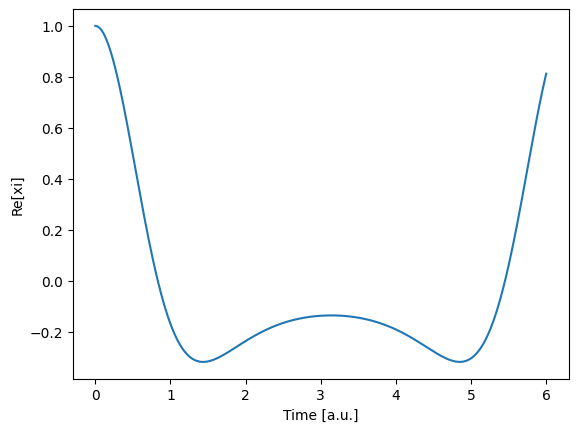

In [33]:
plt.plot(tlist, xir)
plt.xlabel("Time [a.u.]")
plt.ylabel("Re[xi]");

Plot the imaginary part of the autocorrelation function.

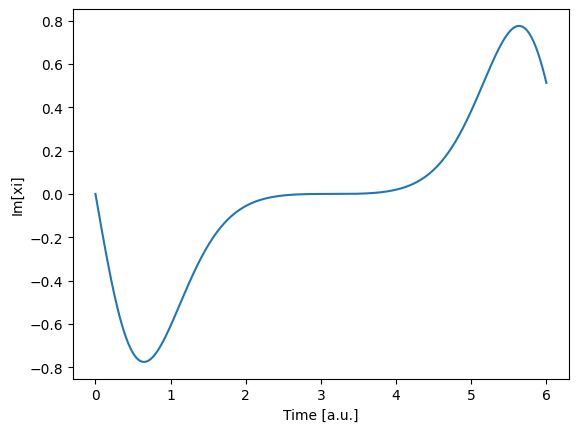

In [34]:
plt.plot(tlist, xii)
plt.xlabel("Time [a.u.]")
plt.ylabel("Im[xi]");

Plot the norm.

Text(0, 0.5, 'Norm')

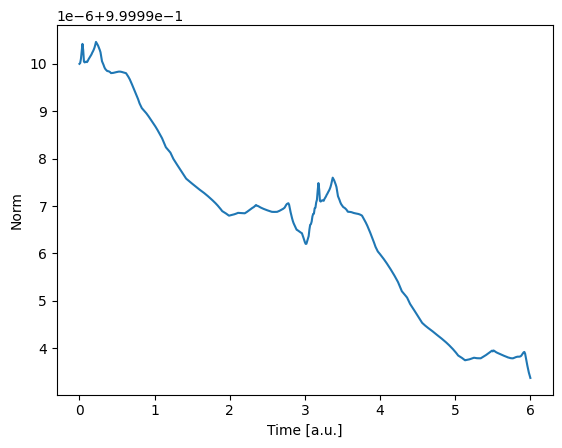

In [35]:
plt.plot(tlist, norm)
plt.xlabel("Time [a.u.]")
plt.ylabel("Norm")

Plot all of the wavepacket snapshots in chronological order.

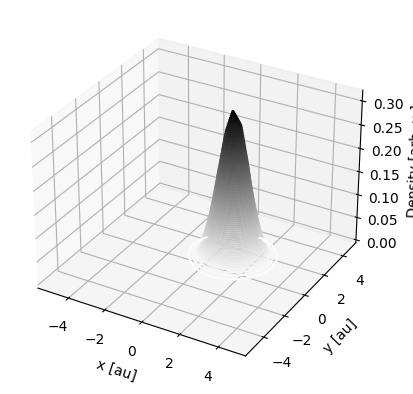

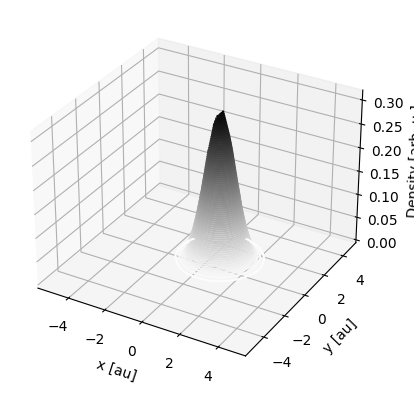

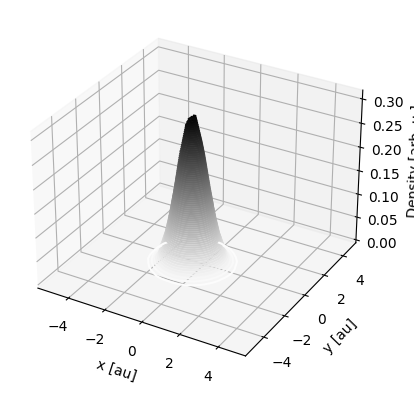

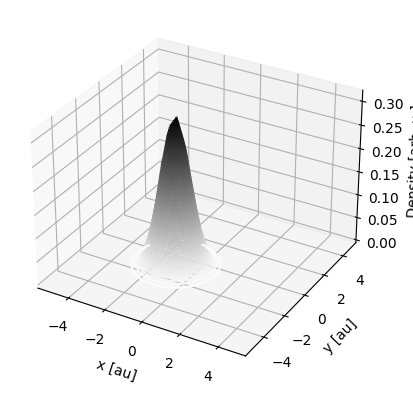

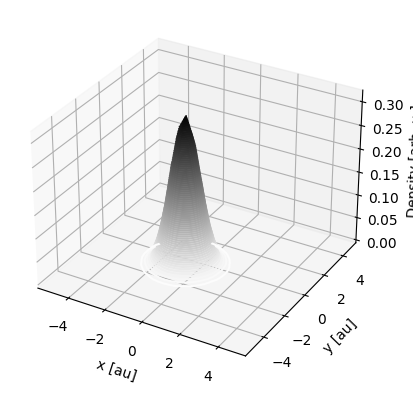

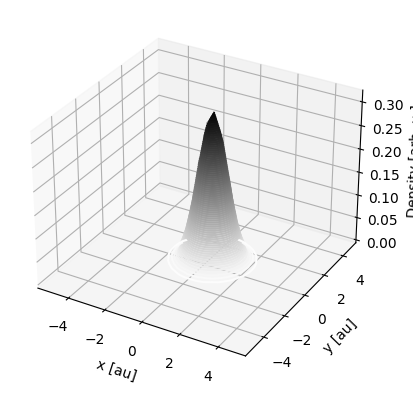

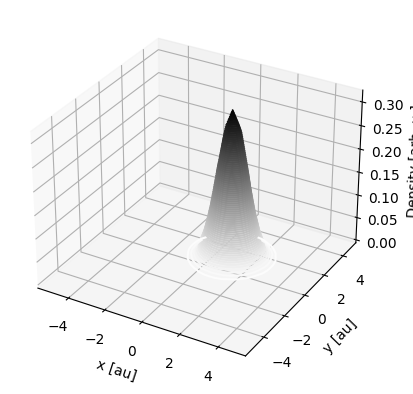

In [ ]:
for ii in range(nsnaps):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax.contour3D(xmesh, ymesh, wavesnaps[ii][:][:], 100, cmap='binary')
  ax.set_xlabel('x [au]')
  ax.set_ylabel('y [au]')
  ax.set_zlabel('Density [arb. u.]');
  plt.show()